In [1]:
!pip install --pre deepchem[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 39.2 MB/s eta 0:00:00


In [2]:
import deepchem as dc
dc.__version__

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [3]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#load the dataset (polymer smiles and their specific gravity)

descriptors = ["BCUT2D_LOGPLOW",
"BCUT2D_MRHI",
"Ipc",
"SlogP_VSA4",
"SlogP_VSA6",
]

print("loading the data...")
loader = dc.data.CSVLoader(["density"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors(descriptors = descriptors))
Data = loader.create_dataset('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/Predicting_T_dependency/csv_files/Combined_dens_Dataset_WithState.csv')

loading the data...


In [6]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0, posinf=0)
print("RDKit:",X.shape)

# now load the additional features
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/Predicting_T_dependency/csv_files/Combined_dens_Dataset_WithState.csv')
state = df["state"].to_numpy()
Ts = df["temp"].to_numpy()

# combine the RDKit descriptors with the simulation temperature and the boiling temperature
input=np.column_stack((X,Ts,state))
print("With TS and State added:",input.shape)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=input, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["denstiy"])

RDKit: (13298, 5)
With TS and State added: (13298, 7)


In [7]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(Dataset, frac_train = 0.8, frac_valid= 0.1, frac_test = 0.1)
print("Data is splitted into: train, valid, test")


Data is splitted into: train, valid, test


In [8]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

kernel = 1 * RationalQuadratic() +WhiteKernel()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


model is fitted


In [9]:

#calculate r2 scores
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
train_r2score = model.evaluate(train_dataset, metric)
valid_r2score = model.evaluate(valid_dataset, metric)
test_r2score= model.evaluate(test_dataset, metric)

#make then useable
testr2=list(test_r2score.values())[0]
validr2=list(valid_r2score.values())[0]
trainr2=list(train_r2score.values())[0]

print("training r2-score:",np.mean(trainr2) )
print("valid r2-score:",np.mean(validr2) )
print("test r2-score:",np.mean(testr2) )

training r2-score: 0.9918618705187323
valid r2-score: 0.9406424385407528
test r2-score: 0.9411738757435727


In [10]:
#calculate RMSE score
import math
from sklearn.metrics import mean_squared_error
MSE_score = mean_squared_error(test_dataset.y,predicted)
RMSE_score = math.sqrt(MSE_score)
print('tets set RMSE-score:',RMSE_score)

tets set RMSE-score: 78.52748424608819


In [11]:
#convert tekst to string, so it can be depicted in matplotlib

text = "test r2= "+ str(round(testr2,4))  + " & RMSE= " +str(round(RMSE_score,4))

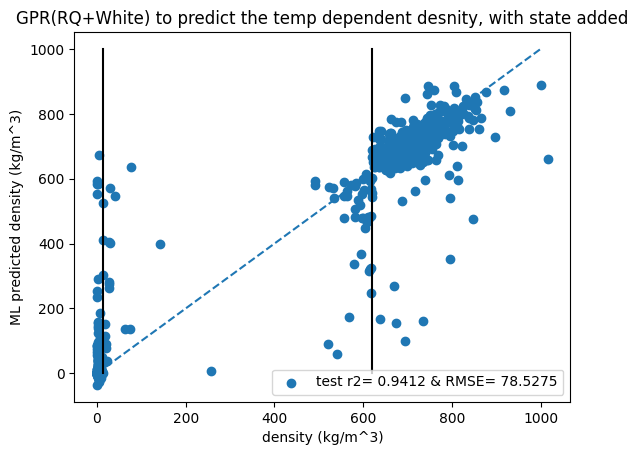

In [12]:
#plot the data
import matplotlib.pyplot as plt

x=[0,1000]
y=[0,1000]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.plot([13,13],[0,1000],c="black")
plt.plot([620,620],[0,1000],c="black")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("density (kg/m^3)")
plt.ylabel("ML predicted density (kg/m^3)")
plt.title("GPR(RQ+White) to predict the temp dependent desnity, with state added")
plt.show()
